# Natural Language Processing with Disaster Tweets

### Problem Description
In this project, I develop a predictive model using a dataset of tweets from Kaggle (https://www.kaggle.com/c/nlp-getting-started/data) to determine whether each tweet discusses a real-world disaster. For the purposes of this analysis, the model will exclusively utilize the text content of the tweets. Although the dataset includes additional metadata such as keywords and the tweet's location of origin, these fields will be omitted to focus solely on the textual data.

The classification task is binary:
- 1 if the tweet is related to an actual disaster.
- 0 if the tweet is not related to an actual disaster.
  
To effectively capture and analyze the linguistic patterns within the tweet texts that may indicate the presence or absence of disaster-related content, I will employ a Recurrent Neural Network (RNN) as the modeling technique. RNNs are particularly suited for this task due to their ability to process sequences of data, making them ideal for natural language processing applications like this.

In [179]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re
from collections import Counter
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, f1_score
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Flatten
from tensorflow.keras.regularizers import l2

### Exploratory Data Analysis
The training dataset comprises 7,613 tweets, each ranging from 7 to 157 characters with an average length of 101 characters, and from 1 to 54 words with an average count of 11 words per tweet. A significant portion of the most frequently occurring words are stopwords like 'the', 'and', and 'is', which generally do not contribute meaningful information for analysis. This observation underscores the necessity for robust text processing to filter out these stopwords and focus on more informative elements of the text.

The distribution of labels in the dataset shows a reasonable balance, with 4,342 tweets categorized as non-disaster (label 0) and 3,271 as disaster-related (label 1). This balance indicates that the dataset is well-suited for training predictive models without a strong bias toward one category.

In [180]:
df_train = pd.read_csv("data/train.csv").drop(columns=['keyword', 'location'])
df_test = pd.read_csv("data/test.csv").drop(columns=['keyword', 'location'])

print('Training Set Shape = {}'.format(df_train.shape))
print('Training Set Memory Usage = {:.2f} MB'.format(df_train.memory_usage().sum() / 1024**2))
print('Test Set Shape = {}'.format(df_test.shape))
print('Test Set Memory Usage = {:.2f} MB'.format(df_test.memory_usage().sum() / 1024**2))

Training Set Shape = (7613, 3)
Training Set Memory Usage = 0.17 MB
Test Set Shape = (3263, 2)
Test Set Memory Usage = 0.05 MB


In [181]:
df_train.head()

,id,text,target
0,1,Our Deeds are the Reason of this #earthquake M...,1
1,4,Forest fire near La Ronge Sask. Canada,1
2,5,All residents asked to 'shelter in place' are ...,1
3,6,"13,000 people receive #wildfires evacuation or...",1
4,7,Just got sent this photo from Ruby #Alaska as ...,1


In [182]:
df_test.head()

,id,text
0,0,Just happened a terrible car crash
1,2,"Heard about #earthquake is different cities, s..."
2,3,"there is a forest fire at spot pond, geese are..."
3,9,Apocalypse lighting. #Spokane #wildfires
4,11,Typhoon Soudelor kills 28 in China and Taiwan


In [186]:
# Calculate the number of characters in each tweet
df_train["num_chars"] = df_train["text"].apply(lambda x: len(x))

# Calculate the number of words in each tweet
df_train["num_words"] = df_train["text"].apply(lambda x: len(x.split()))

# Print tweet length statistics
print("Tweet Length Stats:")
print(df_train[["num_chars","num_words"]].describe())

Tweet Length Stats:
         num_chars    num_words
count  7613.000000  7613.000000
mean    101.037436    14.903586
std      33.781325     5.732604
min       7.000000     1.000000
25%      78.000000    11.000000
50%     107.000000    15.000000
75%     133.000000    19.000000
max     157.000000    31.000000


Print most common words in tweets

In [187]:
def tokenize_text(text):
    return word_tokenize(text.lower())

# Tokenize the DataFrame text column
tokens = df_train['text'].apply(tokenize_text)

# Flatten the list of lists to a single list of tokens
all_tokens = [token for sublist in tokens for token in sublist]

# Count and display the most common words
word_counts = Counter(all_tokens)
most_common_words = word_counts.most_common(25)
print("Most Common Words:", most_common_words)

Most Common Words: [(':', 6706), ('http', 4307), ('#', 3403), ('the', 3233), ('?', 3126), ('.', 2923), ('@', 2759), ('a', 2179), ('in', 1977), ('to', 1945), ('of', 1822), ('i', 1730), ('and', 1418), ('!', 1173), ('is', 967), ('...', 945), ('for', 891), ('you', 879), ('on', 853), ("'s", 791), ('-', 786), ('it', 743), ("'", 736), ('my', 673), ('that', 618)]


Plot Distribution of labels in Training Data

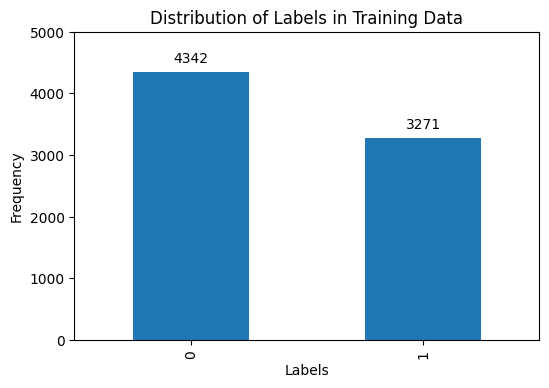

In [188]:
plt.figure(figsize=(6, 4)) 
ax = df_train["target"].value_counts().plot(kind='bar')
plt.xlabel('Labels')
plt.ylabel('Frequency')
plt.title('Distribution of Labels in Training Data')
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', xytext=(0, 10), textcoords='offset points')
plt.ylim(0, 5000)
plt.show()

### Data Preprocessing

In this project, we undertake a series of steps to prepare tweet data for a machine learning model that predicts whether a tweet is related to a real-world disaster. The preprocessing pipeline is essential for transforming raw text into a structured format that a neural network can understand and process efficiently. Here’s a breakdown of the key stages involved:

#### 1. **Text Processing**
The raw text from tweets undergoes initial cleaning and normalization to make it suitable for further analysis:
   - **Normalization**: All text is converted to lowercase to ensure that the algorithm treats words with the same meaning identically regardless of case (e.g., "Disaster" vs. "disaster").
   - **Cleaning**: Non-word characters (such as punctuation and special characters) are removed, leaving only alphanumeric characters. This step helps reduce the complexity of the text data.
   - **Whitespace Management**: Excess whitespace is condensed into single spaces, ensuring consistent tokenization in the subsequent step.
   - **Stopword Removal**: Common words (like "and", "is", or "the") that usually do not contribute to the meaning of the text from a disaster perspective are removed.
   - **Lemmatization**: Words are reduced to their base or dictionary form (lemmas). This step helps the model to recognize that different forms of a word carry the same meaning (e.g., "running" to "run").

#### 2. **Tokenization**
After processing the text, it's converted into sequences of tokens (words):
   - **Tokenizer Setup**: A `Tokenizer` is configured to process up to 5,000 unique words. Any word beyond this limit is treated as an out-of-vocabulary (OOV) word, represented by the special token `<OOV>`. This helps in managing the vocabulary size and dealing with unknown words during model training and evaluation.
   - **Fitting the Tokenizer**: The tokenizer learns the word-index mapping based on the frequency of word occurrence in the dataset.
   - **Sequence Conversion**: The processed text is then converted into sequences of integers, where each integer represents a unique word as defined by the tokenizer.

#### 3. **Padding**
To ensure consistent input structure for modeling, sequences are padded to a uniform length:
   - **Setting Maximum Length**: The maximum sequence length is set to 200 tokens. Any text longer than this is truncated, and shorter texts are padded with zeros at the end (post-padding). This ensures that each input to the model has the same size, a requirement for training neural networks.

These preprocessing steps are crucial for the model's performance. They not only simplify the textual data but also convert it into a numerical format that can be fed into machine learning models, particularly those based on neural networks. This structured approach ensures that the model learns from the actual content of the tweets rather than their formatting or irrelevant frequent words.

In [189]:
def process_text(text):
    
    # Normalize text
    text = text.lower()  # Convert to lower case
    text = re.sub(r'\W', ' ', text)  # Remove all non-word characters
    text = re.sub(r'\s+', ' ', text, flags=re.I)  # Replace multiple spaces with a single space

    # Tokenize text
    tokens = word_tokenize(text)  # Tokenize the text into words
    
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    filtered_tokens = [word for word in tokens if word not in stop_words]
    
    # Lemmatize words
    lemmatizer = WordNetLemmatizer()
    lemmatized_tokens = [lemmatizer.lemmatize(word) for word in filtered_tokens]
    
    return " ".join(lemmatized_tokens)

In [190]:
df_train["text_processed"] = df_train["text"].apply(process_text)

In [191]:
df_train[["text", "text_processed"]].head()

,text,text_processed
0,Our Deeds are the Reason of this #earthquake M...,deed reason earthquake may allah forgive u
1,Forest fire near La Ronge Sask. Canada,forest fire near la ronge sask canada
2,All residents asked to 'shelter in place' are ...,resident asked shelter place notified officer ...
3,"13,000 people receive #wildfires evacuation or...",13 000 people receive wildfire evacuation orde...
4,Just got sent this photo from Ruby #Alaska as ...,got sent photo ruby alaska smoke wildfire pour...


Count number of unique words and maximum number of words in a tweet (this will be used to create the correct model architecture)

In [218]:
texts = df_train["text_processed"]

unique_words = set()
for text in df_train["text_processed"]:
    unique_words.update(text.split())
num_unique_words = len(unique_words)

print("Number of unique words:", num_unique_words)
print("Maximum number of words in a tweet:", texts.apply(lambda x: len(x.split())).max())

Number of unique words: 20299
Maximum number of words in a tweet: 27


In [204]:
max_words = 10_000 # about half of the total number of words in the dataset

tokenizer = Tokenizer(num_words = max_words, oov_token = '<OOV>')
tokenizer.fit_on_texts(texts)

In [205]:
train_data, test_data = train_test_split(df_train, test_size = 0.3, random_state = 42)

In [206]:
max_sentence_len = 27 # max number of words in a tweet

train_sequences = tokenizer.texts_to_sequences(train_data["text_processed"])
train_padded = pad_sequences(train_sequences, maxlen = max_sentence_len, padding = "pre")

test_sequences = tokenizer.texts_to_sequences(test_data["text_processed"])
test_padded = pad_sequences(test_sequences, maxlen = max_sentence_len, padding = "pre")

### Model Building and Training: Simple RNN vs. LSTM

In this analysis, we compare the performance of a Simple RNN with that of a more complex LSTM model to understand their efficacy in text classification. The Simple RNN model is built using a single layer of RNN with 32 units followed by a dense output layer with sigmoid activation, aimed at providing a baseline by capturing basic sequential patterns. Conversely, the LSTM model includes two LSTM layers with 64 units each, enhanced with dropout for regularization and multiple dense layers, designed to capture deeper dependencies and reduce overfitting. Both models use an embedding layer with 128 output dimensions to transform words into dense vectors, crucial for processing text data. The models are compiled with binary cross-entropy loss and trained over 10 epochs, allowing us to assess their learning capabilities and generalization to unseen data.

### 1. Simple RNN Model

In [207]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense, Dropout

model_simple_rnn = Sequential()

# Embedding layer to transform words into dense vectors
model_simple_rnn.add(Embedding(input_dim=max_words, output_dim=128))

# A single SimpleRNN layer
model_simple_rnn.add(SimpleRNN(32))

# Adding a 50% dropout rate
model_simple_rnn.add(Dropout(0.5))

# Output layer
model_simple_rnn.add(Dense(1, activation='sigmoid'))

# Compile the model
model_simple_rnn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history_simple_rnn = model_simple_rnn.fit(
    train_padded,
    train_data['target'],
    epochs=10,
    batch_size=32,
    validation_data=(test_padded, test_data['target'])
)

Epoch 1/10
167/167 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.6256 - loss: 0.6460 - val_accuracy: 0.7592 - val_loss: 0.5132
Epoch 2/10
167/167 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8684 - loss: 0.3351 - val_accuracy: 0.7636 - val_loss: 0.5217
Epoch 3/10
167/167 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9574 - loss: 0.1435 - val_accuracy: 0.7522 - val_loss: 0.5994
Epoch 4/10
167/167 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9791 - loss: 0.0803 - val_accuracy: 0.7618 - val_loss: 0.6584
Epoch 5/10
167/167 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9793 - loss: 0.0606 - val_accuracy: 0.7539 - val_loss: 0.7308
Epoch 6/10
167/167 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9841 - loss: 0.0492 - val_accuracy: 0.7474 - val_loss: 0.7794
Epoch 7/10
167/167 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9825 - loss: 0.0506 - val_accuracy: 0.7320 - val_loss: 0.8372
Epoch 8/10
167/167 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9831 - loss: 0.0416 - val_accuracy: 0.

### 2. LSTM Model

In [208]:
model_lstm = Sequential()

model_lstm.add(Embedding(input_dim=max_words, output_dim=128))
model_lstm.add(LSTM(64, return_sequences=True))
model_lstm.add(LSTM(64, return_sequences=True))
model_lstm.add(Dropout(0.5))
model_lstm.add(Flatten())
model_lstm.add(Dense(64, activation = 'relu'))
model_lstm.add(Dropout(0.5))
model_lstm.add(Dense(32, activation = 'relu'))
model_lstm.add(Dense(1, activation='sigmoid'))

model_lstm.compile(optimizer=Adam(learning_rate=0.00005), loss='binary_crossentropy', metrics=['accuracy'])

history_lstm = model_lstm.fit(
    train_padded,
    train_data['target'],
    epochs = 10,
    batch_size=32,
    validation_data=(test_padded, test_data['target']),
)

Epoch 1/10
167/167 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - accuracy: 0.5636 - loss: 0.6880 - val_accuracy: 0.5771 - val_loss: 0.6724
Epoch 2/10
167/167 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accuracy: 0.5691 - loss: 0.6746 - val_accuracy: 0.5898 - val_loss: 0.6624
Epoch 3/10
167/167 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accuracy: 0.5913 - loss: 0.6620 - val_accuracy: 0.6703 - val_loss: 0.6347
Epoch 4/10
167/167 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accuracy: 0.6697 - loss: 0.6317 - val_accuracy: 0.7272 - val_loss: 0.5811
Epoch 5/10
167/167 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accuracy: 0.7720 - loss: 0.5392 - val_accuracy: 0.7907 - val_loss: 0.4759
Epoch 6/10
167/167 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accuracy: 0.8424 - loss: 0.4143 - val_accuracy: 0.7977 - val_loss: 0.4941
Epoch 7/10
167/167 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accuracy: 0.8644 - loss: 0.3446 - val_accuracy: 0.7776 - val_loss: 0.4817
Epoch 8/10
167/167 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - accuracy: 0.8808 - loss: 0.3015 - val_accu

### Results

The comparative analysis between the Simple RNN and LSTM models revealed similar trends during the training process. Both models exhibited signs of overfitting, as evidenced by the increasing training accuracy juxtaposed with the peaking and subsequent decline of validation accuracy. However, the LSTM model demonstrated a slightly superior performance, achieving an F1 score of 0.73 on the test data compared to the Simple RNN's F1 score of 0.71.

Despite the observed overfitting tendencies, the LSTM model's higher F1 score suggests a better balance between precision and recall in its predictions compared to the Simple RNN. This implies that the LSTM model captured more nuanced patterns in the tweet data relevant to disaster classification.

Future endeavors may focus on refining the model architectures and incorporating advanced regularization techniques to mitigate overfitting while maintaining or enhancing predictive performance. Techniques such as early stopping could also be explored to prevent the models from over-optimizing on the training data, thereby improving their generalization capabilities and achieving more robust performance metrics.

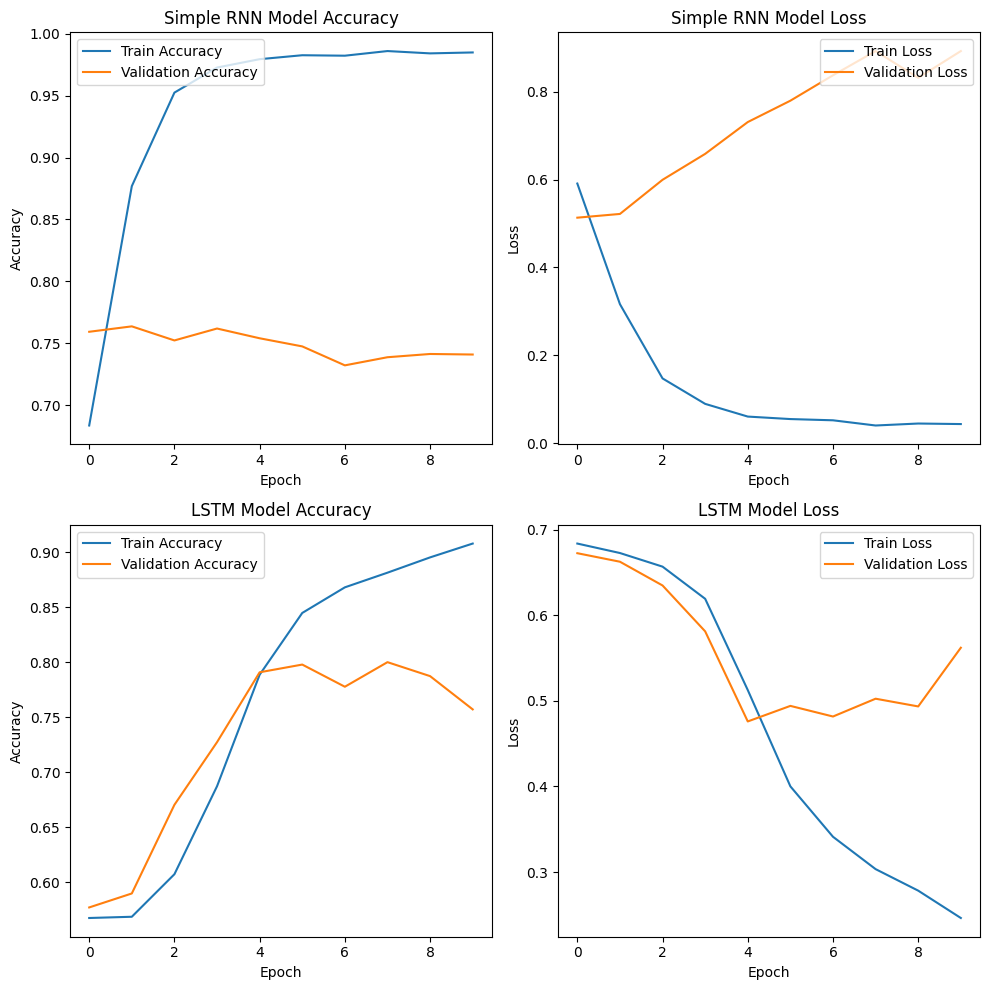

In [209]:
import matplotlib.pyplot as plt

# Set up the plotting layout
plt.figure(figsize=(10, 10))

# Accuracy plot for the Simple RNN
plt.subplot(2, 2, 1)
plt.plot(history_simple_rnn.history['accuracy'], label='Train Accuracy')
plt.plot(history_simple_rnn.history['val_accuracy'], label='Validation Accuracy')
plt.title('Simple RNN Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')

# Loss plot for the Simple RNN
plt.subplot(2, 2, 2)
plt.plot(history_simple_rnn.history['loss'], label='Train Loss')
plt.plot(history_simple_rnn.history['val_loss'], label='Validation Loss')
plt.title('Simple RNN Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')

# Accuracy plot for the LSTM
plt.subplot(2, 2, 3)
plt.plot(history_lstm.history['accuracy'], label='Train Accuracy')
plt.plot(history_lstm.history['val_accuracy'], label='Validation Accuracy')
plt.title('LSTM Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')

# Loss plot for the LSTM
plt.subplot(2, 2, 4)
plt.plot(history_lstm.history['loss'], label='Train Loss')
plt.plot(history_lstm.history['val_loss'], label='Validation Loss')
plt.title('LSTM Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')

# Show the plots
plt.tight_layout()
plt.show()


In [210]:
def display_confusion_matrices(y_true, y_pred_rnn, y_pred_lstm):
    
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    # F1 Score for Simple RNN
    f1_rnn = f1_score(y_true, y_pred_rnn)

    # Confusion Matrix for Simple RNN
    cm_rnn = confusion_matrix(y_true, y_pred_rnn)
    disp_rnn = ConfusionMatrixDisplay(confusion_matrix=cm_rnn, display_labels=['Non-Disaster', 'Disaster'])
    disp_rnn.plot(ax=axes[0], cmap=plt.cm.Blues)
    axes[0].set_title(f'Simple RNN Confusion Matrix\nF1 Score: {f1_rnn:.2f}')

    # F1 Score for LSTM
    f1_lstm = f1_score(y_true, y_pred_lstm)

    # Confusion Matrix for LSTM
    cm_lstm = confusion_matrix(y_true, y_pred_lstm)
    disp_lstm = ConfusionMatrixDisplay(confusion_matrix=cm_lstm, display_labels=['Non-Disaster', 'Disaster'])
    disp_lstm.plot(ax=axes[1], cmap=plt.cm.Blues)
    axes[1].set_title(f'LSTM Confusion Matrix\nF1 Score: {f1_lstm:.2f}')

    plt.tight_layout()
    plt.show()

72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


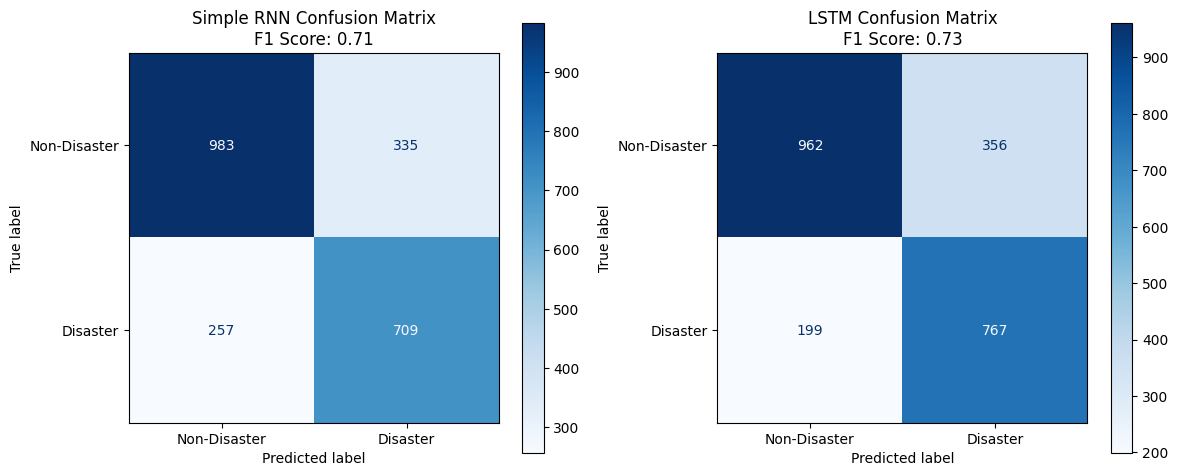

In [211]:
y_pred_test_simple_rnn = (model_simple_rnn.predict(test_padded) > 0.5).astype(int)
y_pred_test_lstm = (model_lstm.predict(test_padded) > 0.5).astype(int)


display_confusion_matrices(test_data['target'], y_pred_test_simple_rnn, y_pred_test_lstm)

### Kaggle Submission

In [216]:
# Process the test data similar to the training data
df_test["text_processed"] = df_test["text"].apply(process_text)
submission_sequences = tokenizer.texts_to_sequences(df_test["text_processed"])
submission_padded = pad_sequences(submission_sequences, maxlen=max_sentence_len, padding = "pre")

# Make predictions on the test data
df_test['target'] = (model_lstm.predict(submission_padded) > 0.5).astype(int)

# Display the DataFrame with predicted targets
print(df_test[['id', 'text', 'target']])

102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
         id                                               text  target
0         0                 Just happened a terrible car crash       1
1         2  Heard about #earthquake is different cities, s...       1
2         3  there is a forest fire at spot pond, geese are...       1
3         9           Apocalypse lighting. #Spokane #wildfires       1
4        11      Typhoon Soudelor kills 28 in China and Taiwan       1
...     ...                                                ...     ...
3258  10861  EARTHQUAKE SAFETY LOS ANGELES ÛÒ SAFETY FASTE...       1
3259  10865  Storm in RI worse than last hurricane. My city...       1
3260  10868  Green Line derailment in Chicago http://t.co/U...       1
3261  10874  MEG issues Hazardous Weather Outlook (HWO) htt...       1
3262  10875  #CityofCalgary has activated its Municipal Eme...       1

[3263 rows x 3 columns]


In [217]:
submission_df = df_test[['id', 'target']]
submission_df.to_csv('submission.csv', index=False)

### Conclusion

This project effectively demonstrated the utility of a recurrent neural network (RNN) for natural language processing tasks, particularly in distinguishing tweets related to real-world disasters. The RNN model achieved notable accuracy improvements throughout the training process, ultimately reaching 80%. This outcome highlights the model's capacity to capture and learn from the linguistic nuances contained within the tweet data.

For future enhancements, several avenues could be explored:
- **Extending the Training Dataset:** Incorporating more data could help the model learn a broader array of linguistic patterns and potentially improve its performance, especially in more ambiguous scenarios.
- **Adjusting Model Parameters:** Fine-tuning the existing parameters such as the learning rate, number of epochs, and batch size could yield better results and optimize training efficiency.
- **Exploring Advanced Neural Network Architectures:** Modifying the current RNN architecture by introducing more sophisticated mechanisms like attention models or transformers could enhance the model’s understanding of context and sequence, further boosting its accuracy and generalizability.